In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os

# Google Drive mounting and setup
from google.colab import drive
drive.mount('/content/drive')

# Create directory for saving checkpoints
checkpoint_dir = '/content/drive/MyDrive/FER_Checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


Mounted at /content/drive


In [ ]:
x = pd.read_csv('fer2013.csv')
y = x.values[:, 0]
pixels = x.values[:, 1]


In [ ]:
def load_data(pixels):
    X = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in pixels])
    return X.reshape(-1, 48, 48, 1)

X = load_data(pixels)

X = X.astype('float32') / 255.0

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean) / (X_std + 1e-7)


In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

y_train = to_categorical(y_train, 7)
y_val = to_categorical(y_val, 7)
y_test = to_categorical(y_test, 7)

In [ ]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    shear_range=0.1
)

datagen.fit(X_train)

In [ ]:
def find_latest_checkpoint(checkpoint_dir):
    """Find the latest checkpoint file"""
    checkpoint_files = []
    for file in os.listdir(checkpoint_dir):
        if file.startswith('model_epoch_') and file.endswith('.h5'):
            epoch_num = int(file.split('_')[2].split('.')[0])
            checkpoint_files.append((epoch_num, file))

    if checkpoint_files:
        checkpoint_files.sort(reverse=True)  # Sort by epoch number, descending
        latest_epoch, latest_file = checkpoint_files[0]
        return latest_epoch, os.path.join(checkpoint_dir, latest_file)
    return 0, None

def create_improved_model():
    model = Sequential([
        # First Convolutional Block
        Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fourth Convolutional Block - removed to prevent dimension issues
        # Conv2D(512, (3, 3), activation='relu'),
        # BatchNormalization(),
        # Dropout(0.25),

        # Flatten instead of GlobalAveragePooling2D for this architecture
        Flatten(),

        # Dense layers with progressive dropout
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(7, activation='softmax')
    ])

    return model

model = create_improved_model()

# Check for existing checkpoints and load if available
latest_epoch, checkpoint_path = find_latest_checkpoint(checkpoint_dir)
initial_epoch = 0

if checkpoint_path and os.path.exists(checkpoint_path):
    print(f"Found checkpoint at epoch {latest_epoch}: {checkpoint_path}")
    try:
        model = tf.keras.models.load_model(checkpoint_path)
        initial_epoch = latest_epoch
        print(f"Loaded model from epoch {latest_epoch}. Training will resume from epoch {latest_epoch + 1}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Starting training from scratch...")
        model = create_improved_model()
        initial_epoch = 0
else:
    print("No checkpoint found. Starting training from scratch...")
    model = create_improved_model()

optimizer = AdamW(
    learning_rate=0.001,
    weight_decay=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', 'precision', 'recall']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found checkpoint at epoch 40: /content/drive/MyDrive/FER_Checkpoints/model_epoch_040.h5


Loaded model from epoch 40. Training will resume from epoch 41


In [ ]:
# Custom callback to save every 10 epochs
class SaveEvery10Epochs(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_dir, initial_epoch=0):
        super(SaveEvery10Epochs, self).__init__()
        self.checkpoint_dir = checkpoint_dir
        self.initial_epoch = initial_epoch

    def on_epoch_end(self, epoch, logs=None):
        actual_epoch = epoch + self.initial_epoch + 1
        if actual_epoch % 10 == 0:
            checkpoint_path = os.path.join(self.checkpoint_dir, f'model_epoch_{actual_epoch:03d}.h5')
            self.model.save(checkpoint_path)
            print(f'\nSaved checkpoint at epoch {actual_epoch}: {checkpoint_path}')

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_emotion_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    # Add the custom callback for saving every 10 epochs
    SaveEvery10Epochs(checkpoint_dir, initial_epoch),
    # Additional ModelCheckpoint to save best model to Google Drive
    ModelCheckpoint(
        os.path.join(checkpoint_dir, 'best_emotion_model_gdrive.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [ ]:
batch_size = 32
epochs = 50  # Total epochs you want to train
remaining_epochs = epochs - initial_epoch

print(f"Total epochs: {epochs}")
print(f"Starting from epoch: {initial_epoch + 1}")
print(f"Remaining epochs to train: {remaining_epochs}")
print("Model Summary:")
model.summary()




Total epochs: 50
Starting from epoch: 41
Remaining epochs to train: 10
Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,003,143 (22.90 MB)

 Trainable params: 5,999,815 (22.89 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [ ]:

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs,
    initial_epoch=initial_epoch,  # This is key for resuming training
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 41/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4888 - loss: 1.3524 - precision: 0.6940 - recall: 0.2672
Epoch 41: val_accuracy improved from -inf to 0.56267, saving model to best_emotion_model.h5



Epoch 41: val_accuracy improved from -inf to 0.56267, saving model to /content/drive/MyDrive/FER_Checkpoints/best_emotion_model_gdrive.h5


785/785 ━━━━━━━━━━━━━━━━━━━━ 1540s 2s/step - accuracy: 0.4888 - loss: 1.3524 - precision: 0.6940 - recall: 0.2672 - val_accuracy: 0.5627 - val_loss: 1.1619 - val_precision: 0.7542 - val_recall: 0.3617 - learning_rate: 0.0010
Epoch 42/50
  1/785 ━━━━━━━━━━━━━━━━━━━━ 23:07 2s/step - accuracy: 0.5312 - loss: 1.0351 - precision: 0.7500 - recall: 0.2812

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 42: val_accuracy did not improve from 0.56267

Epoch 42: val_accuracy did not improve from 0.56267
785/785 ━━━━━━━━━━━━━━━━━━━━ 84s 105ms/step - accuracy: 0.5312 - loss: 1.0351 - precision: 0.7500 - recall: 0.2812 - val_accuracy: 0.5617 - val_loss: 1.1626 - val_precision: 0.7529 - val_recall: 0.3621 - learning_rate: 0.0010
Epoch 43/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4972 - loss: 1.2953 - precision: 0.6964 - recall: 0.2822
Epoch 43: val_accuracy improved from 0.56267 to 0.56770, saving model to best_emotion_model.h5



Epoch 43: val_accuracy improved from 0.56267 to 0.56770, saving model to /content/drive/MyDrive/FER_Checkpoints/best_emotion_model_gdrive.h5


785/785 ━━━━━━━━━━━━━━━━━━━━ 1548s 2s/step - accuracy: 0.4972 - loss: 1.2953 - precision: 0.6964 - recall: 0.2822 - val_accuracy: 0.5677 - val_loss: 1.1500 - val_precision: 0.7444 - val_recall: 0.3574 - learning_rate: 0.0010
Epoch 44/50
  1/785 ━━━━━━━━━━━━━━━━━━━━ 19:56 2s/step - accuracy: 0.5312 - loss: 1.3918 - precision: 0.6667 - recall: 0.2500
Epoch 44: val_accuracy did not improve from 0.56770

Epoch 44: val_accuracy did not improve from 0.56770
785/785 ━━━━━━━━━━━━━━━━━━━━ 83s 105ms/step - accuracy: 0.5312 - loss: 1.3918 - precision: 0.6667 - recall: 0.2500 - val_accuracy: 0.5668 - val_loss: 1.1529 - val_precision: 0.7399 - val_recall: 0.3565 - learning_rate: 0.0010
Epoch 45/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5020 - loss: 1.2739 - precision: 0.6979 - recall: 0.2935
Epoch 45: val_accuracy did not improve from 0.56770

Epoch 45: val_accuracy did not improve from 0.56770
785/785 ━━━━━━━━━━━━━━━━━━━━ 1487s 2s/step - accuracy: 0.5020 - loss: 1.2739 - precision: 


Epoch 49: val_accuracy improved from 0.56770 to 0.57664, saving model to /content/drive/MyDrive/FER_Checkpoints/best_emotion_model_gdrive.h5


785/785 ━━━━━━━━━━━━━━━━━━━━ 1477s 2s/step - accuracy: 0.5181 - loss: 1.2210 - precision: 0.7174 - recall: 0.3159 - val_accuracy: 0.5766 - val_loss: 1.1340 - val_precision: 0.7364 - val_recall: 0.3908 - learning_rate: 5.0000e-04
Epoch 50/50
  1/785 ━━━━━━━━━━━━━━━━━━━━ 20:44 2s/step - accuracy: 0.5312 - loss: 2.0258 - precision: 0.7143 - recall: 0.3125
Epoch 50: val_accuracy did not improve from 0.57664



Saved checkpoint at epoch 90: /content/drive/MyDrive/FER_Checkpoints/model_epoch_090.h5

Epoch 50: val_accuracy did not improve from 0.57664
785/785 ━━━━━━━━━━━━━━━━━━━━ 84s 105ms/step - accuracy: 0.5312 - loss: 2.0258 - precision: 0.7143 - recall: 0.3125 - val_accuracy: 0.5752 - val_loss: 1.1341 - val_precision: 0.7368 - val_recall: 0.3906 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 49.


In [ ]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Save final model to Google Drive
final_model_path = os.path.join(checkpoint_dir, 'final_emotion_model.h5')
model.save(final_model_path)
print(f"\nFinal model saved to: {final_model_path}")


Test Results:
Test Accuracy: 0.5684
Test Precision: 0.7306
Test Recall: 0.3978

Final model saved to: /content/drive/MyDrive/FER_Checkpoints/final_emotion_model.h5


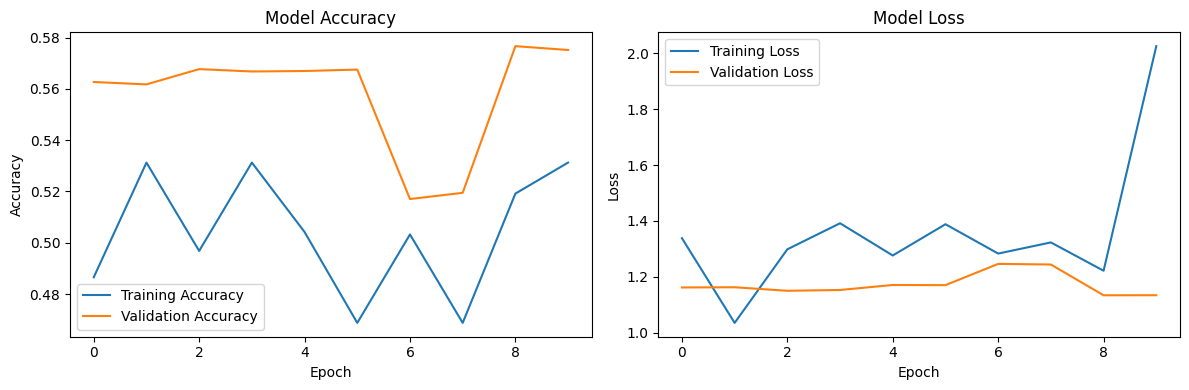


Training plots saved to: /content/drive/MyDrive/FER_Checkpoints/training_plots.png
Training history saved to: /content/drive/MyDrive/FER_Checkpoints/training_history.npy

All checkpoints and files saved to: /content/drive/MyDrive/FER_Checkpoints
You can find them in your Google Drive under 'FER_Checkpoints' folder.


<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save training plots to Google Drive
plots_path = os.path.join(checkpoint_dir, 'training_plots.png')
plt.savefig(plots_path, dpi=300, bbox_inches='tight')
print(f"\nTraining plots saved to: {plots_path}")

# Save training history to Google Drive
history_path = os.path.join(checkpoint_dir, 'training_history.npy')
np.save(history_path, history.history)
print(f"Training history saved to: {history_path}")

print(f"\nAll checkpoints and files saved to: {checkpoint_dir}")
print("You can find them in your Google Drive under 'FER_Checkpoints' folder.")